In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
class Value:
    def __init__(self, data, _children=() , _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.grad = 0.0
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        out.label = self.label + '+' + other.label
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data ** other,(self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
        
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(x, (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out

    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()
        
# a = Value(3.0, label='a')
# b = Value(-2.0, label='b')
# c = Value(5.0, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label ='d'
# f = Value(-2.0, label='f')
# L = d * f
# L.label = 'L'


In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(value):
        if value not in nodes:
            nodes.add(value)
            for child in value._prev:
                edges.add((child, value))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # for any value in a grpahql create rectangular node for it
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (node.label, node.data, node.grad ),
                 shape='record')
        if node._op:
            dot.node(name = uid + node._op, label = node._op)
            dot.edge(uid + node._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
                


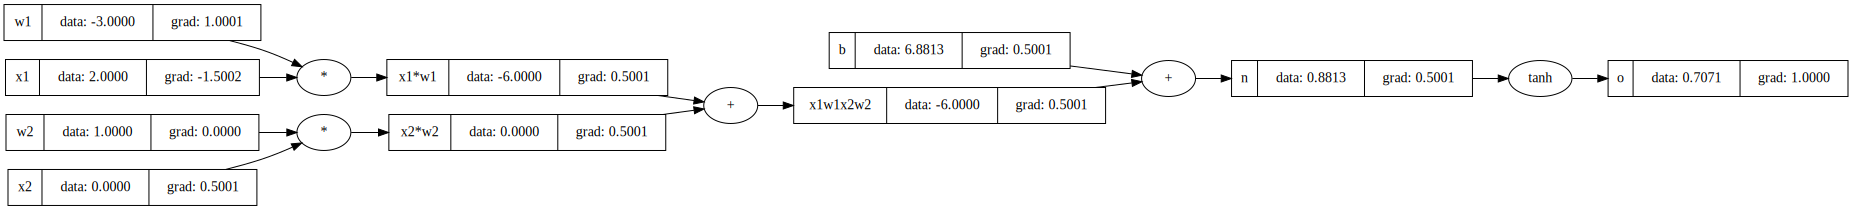

In [6]:
# input x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1  + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import random

class Neuron:
        
    def __init__(self, nin):
            self.weights = [Value(random.uniform(-1, 1), label=f'w{i}') for i in range(nin)] 
            self.b = Value(random.uniform(-1, 1), label='b')

    def __call__(self, xs):
        # w * x + b
        # wixis = [(xi.label = f'x{i}', wi*xi) for i, (wi, xi) in enumerate(zip(self.w, xs))]
        weights_and_xis = []
        for i, (wi, xi) in enumerate(zip(self.weights, xs)):
            xi = Value(xi, label=f'x{i}')
            product = wi*xi
            product.label = wi.label +'*' + xi.label
            weights_and_xis.append(product)
        act = sum(weights_and_xis, self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.b]
    
class Layer:
#     nin - imput neurons
#     nout - output neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()] 

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

x = [1.0, 2.0]
print(x)
# n(x)
# v = Value(1)

# n(x)
expected = [1.0]
number_of_inputs = len(x)
number_of_outputs_for_each_layer = [1]
mlp = MLP(number_of_inputs, number_of_outputs_for_each_layer)
result = mlp(x)
draw_dot(result)
# result = neuron(x)